# ADMM-based Neural Network Optimizer Tutorial

This is a tutorial for the ADMM-based Convex reformulation of the ReLU-activated 2-layer Neural Network training problem. We show training and inference on a subset of the CIFAR-10 dataset.

### Setup

Before running the below cell, make sure to set up the Python enviroment with all necessary supporting packages using the following lines in a command window:

```
conda env create -f env.yml
conda activate cvxenv
```


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from relu_solver import CReLU_MLP
from utils.relu_utils import classifcation_accuracy, binary_classifcation_accuracy, squared_loss, cross_entropy_loss
from utils.load_data import load_cifar

Let's load a subset of the CIFAR-10 dataset for this tutorial. We reshape the training data into an $N \times d$ matrix and subsample to a binary classification problem for the sake of this tutorial.

In [ ]:
from tensorflow import keras
from utils.load_data import preprocess_cifar10

# preprocess data into N x d matrices and downsample into binary class data for demo
(X_train,Y_train),(X_test,Y_test) = keras.datasets.cifar10.load_data()

X_train,Y_train,X_test,Y_test = preprocess_cifar10(X_train=X_train, 
                                                  X_test=X_test, 
                                                  Y_train=Y_train, 
                                                  Y_test=Y_test, 
                                                  n_train=10000,
                                                  n_test=1000, 
                                                  downsample=True, 
                                                  binary_classes=True)
                                                  
print(f'The shape of X_train is : {X_train.shape}','\t',f'The shape of Y_train is : {Y_train.shape}','\n',
     f'The shape of X_test is : {X_test.shape}','\t',f'The shape of y_test is : {Y_test.shape}')


### Optimizer Training

First, create an instance of a ```CRelu_MLP``` object with the specific optimization parameters listed below (not exhaustive).

In [3]:
"""########################### PARAMETERS  ##############################"""
# load to 'cpu' or 'cuda' for GPU usage
device = 'cpu' 
# optimizer mode: choose 'ADMM' for full solve or 'ADMM-RBCD' for approximate solve
optimizer_mode = 'ADMM-RBCD'
# datatype backend to use for gpu: 'numpy', 'jax', or 'torch'. Use 'jax' or 'torch' for GPU acceleration (torch reccomended)
datatype_backend = 'torch'
# number of hidden layers in network (~10-100 reccomended)
num_hidden_layers = 10
# choose between 'binary_classification_accuracy' (reccomended for binary class problems) and 'classification_accuracy' (k class problems)
accuracy_func = binary_classifcation_accuracy
# choose between 'mse' (mean squared error) and 'ce' (cross entropy loss)
loss_type = 'mse'
# random seed
seed = 35791
# set true to run optimizations with memory efficiency preferred over time efficiency (required at high data dimensions to prevent OOM)
save_memory = False

## Set up the Convex Relu Solver
optimizer_config = dict(
    optimizer_mode= optimizer_mode,
    datatype_backend = datatype_backend,
    loss_type = loss_type,
    P_S = num_hidden_layers,
    acc_func = accuracy_func,
    verbose_initialization=True,
    seed=seed,
    memory_save = save_memory,
)
solver = CReLU_MLP(X_train, Y_train, **optimizer_config)

###### Initializing CReLU MLP! ########
	Selected mode: ADMM-RBCD. Using optimizer: <function admm_optimizer at 0x17e97b9d0>
	Using backend: torch.
***** Initializing ADMM-RBCD Parameters ****
  - Warning: solver param "optimality_tolerance" not specified. Using default: 0.001.
  - Warning: solver param "bias" not specified. Using default: True.
  - Warning: solver param "beta" not specified. Using default: 0.0001.
  - Warning: solver param "rho" not specified. Using default: 0.02.
  - Warning: solver param "alpha0" not specified. Using default: 3e-06.
  - Warning: solver param "RBCD_blocksize" not specified. Using default: 3.
  - Warning: solver param "RBCD_thresh" not specified. Using default: 0.7.
  - Warning: solver param "RBCD_thresh_decay" not specified. Using default: 0.96.
  - Warning: solver param "gamma_ratio" not specified. Using default: 0.2.
  - Warning: solver param "gamma_ratio_decay" not specified. Using default: 0.99.
  - Warning: solver param "base_buffer_size" not sp

Training is done with a simple call of ```.optimize()``` on the ```CReLU_MLP``` object. This also returns a ```metrics``` dictionary that contains the solver loss and accuracy per iteration step, as well as information about the compute time breakdowns per iteration and per optimization step.

In [4]:
## Run the solver
metrics = solver.optimize(max_iter=10, verbose=True, X_val=X_test, y_val=Y_test)


Beginning optimization! Mode: ADMM-RBCD
  Sampling hyperplane cuts (D_h matrices)...
	d_diags.shape: torch.Size([10000, 10])
  Completing precomputations...
	Pre Computations Took 0.004s

Beginning descent with maximum 10 iterations and max solve time of 120: 
  Beginning RBCD update...
	loss = mse
	Iteration 20 , alpha: 9.983013117533393e-07 , delta: tensor(45.6356)
	Iteration 40 , alpha: 1.1772402575634683e-06 , delta: tensor(9.3904)
	Iteration 60 , alpha: 9.255018885323788e-07 , delta: tensor(4.3336)
	Iteration 80 , alpha: 1.0913920164221283e-06 , delta: tensor(3.2476)
	Iteration 100 , alpha: 1.287016858927012e-06 , delta: tensor(2.4280)
	Iteration 120 , alpha: 1.011804112080955e-06 , delta: tensor(1.3793)
	Iteration 140 , alpha: 4.772653384249045e-07 , delta: tensor(1.2868)
	Iteration 160 , alpha: 9.380200201390927e-07 , delta: tensor(0.9880)
	Iteration 180 , alpha: 7.374359605376533e-07 , delta: tensor(0.9730)
	Iteration 200 , alpha: 8.696165074602347e-07 , delta: tensor(0.8936)


### Inference

Inference is completed with ```.predict()```:

In [5]:
y_hat = solver.predict(X=X_test)

# get accuracy
print(f"Test Accuracy = {accuracy_func(y_hat, Y_test)*100}%")

Test Accuracy = 83.5%


We can also plot the validation performance per iteration of the ADMM solver:

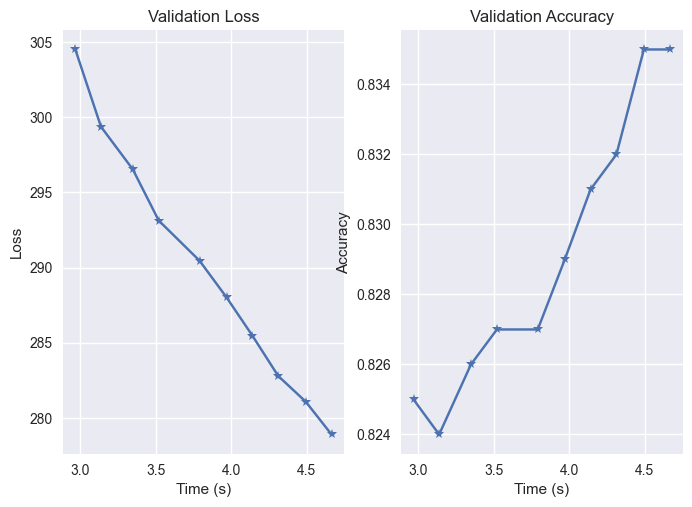

In [6]:
plt.subplot(1,2,1)
plt.plot(metrics["iteration_timepoints"], metrics["val_loss"], '-*')
plt.title("Validation Loss")
plt.xlabel("Time (s)")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(metrics["iteration_timepoints"], metrics["val_acc"], '-*')
plt.title("Validation Accuracy")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.show()

### Other Optimization Methods

Here we compare solving the same problem with different approximations of the Primal update step, including RBCD (shown above), a Conjugate Gradient, and a Preconditioned Conjugate Gradient. Note the time complexity / accuracy trade-off.

In [7]:
"""########################### PARAMETERS  ##############################"""

# # ----------- ADMM solved via Randomized Block Coordinate Descent ------------
optimizer_config = dict(
    optimizer_mode= 'ADMM-RBCD',
    datatype_backend = 'torch',
    loss_type = 'mse',
    P_S = 10,
    acc_func = binary_classifcation_accuracy,
    verbose_initialization=False,
    seed=35791,
    memory_save = False,
)
solver = CReLU_MLP(X_train, Y_train, **optimizer_config)
metrics = solver.optimize(max_iter=10, verbose=False, X_val=X_test, y_val=Y_test)
y_hat = solver.predict(X=X_test)
solve_time = round(metrics["solve_time_breakdown"]["total_time"],3)
print(f"Test Accuracy for ADMM with RBCD = {accuracy_func(y_hat, Y_test)*100}%, Time = {solve_time}s")

# # ----------- ADMM solved via Conjugate Gradient ------------
optimizer_config = dict(
    optimizer_mode= 'ADMM',
    datatype_backend = 'torch',
    loss_type = 'mse',
    P_S = 10,
    acc_func = binary_classifcation_accuracy,
    verbose_initialization=False,
    seed=35791,
    memory_save = False,
    admm_solve_type='cg',
    cg_max_iters=10,
    cg_eps=1e-6,
)
solver = CReLU_MLP(X_train, Y_train, **optimizer_config)
metrics = solver.optimize(max_iter=10, verbose=False, X_val=X_test, y_val=Y_test)
y_hat = solver.predict(X=X_test)
solve_time = round(metrics["solve_time_breakdown"]["total_time"],3)
print(f"Test Accuracy for ADMM with CG = {accuracy_func(y_hat, Y_test)*100}%, Time = {solve_time}s")

# # ----------- ADMM solved via Nystrom-Preconditioned Conjugate Gradient ------------
optimizer_config = dict(
    optimizer_mode= 'ADMM',
    datatype_backend = 'torch',
    loss_type = 'mse',
    P_S = 10,
    acc_func = binary_classifcation_accuracy,
    verbose_initialization=False,
    seed=35791,
    memory_save = False,
    admm_solve_type='cg',
    cg_max_iters=10,
    cg_eps=1e-6,
    cg_preconditioner='nystrom',
)
solver = CReLU_MLP(X_train, Y_train, **optimizer_config)
metrics = solver.optimize(max_iter=10, verbose=False, X_val=X_test, y_val=Y_test)
y_hat = solver.predict(X=X_test)
solve_time = round(metrics["solve_time_breakdown"]["total_time"],3)
print(f"Test Accuracy for ADMM with Nystrom-Preconditioned CG = {accuracy_func(y_hat, Y_test)*100}%, Time = {solve_time}s")

Test Accuracy for ADMM with RBCD = 83.3%, Time = 4.549s
Test Accuracy for ADMM with CG = 84.2%, Time = 7.651s
Test Accuracy for ADMM with Nystrom-Preconditioned CG = 85.0%, Time = 14.889s
